<a href="https://colab.research.google.com/github/jonathan18wjn/jonathan18wjn/blob/main/Homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# helper function to plot top positive and negative coefficients

def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")


### Part 1: Build a classification model using text data

In [3]:
# Read in the data
X = pd.read_csv("X_train.csv")
y = pd.read_csv("y_train.csv")

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.loc[:,"headline"],y.loc[:,"label"],random_state=42)


In [23]:
X.head()

,Unnamed: 0,headline
0,0,MyBook Disk Drive Handles Lots of Easy Backups
1,1,CIT Posts Eighth Loss in a Row
2,2,"Candy Carson Singing The ""National Anthem"" Is ..."
3,3,Why You Need To Stop What You're Doing And Dat...
4,4,27 Times Adele Proved She's Actually The Reale...


In [21]:
y.head()

,Unnamed: 0,label
0,13620,not clickbait
1,15394,not clickbait
2,2796,clickbait
3,1673,clickbait
4,13020,clickbait


##### Vectorization Method 1 CountVectorizer ngram_range = (1,1)

In [12]:
# Vectorization
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1, 1), stop_words="english")
X_train1 = vect.fit_transform(X_train)
X_test1 = vect.transform(X_test)
y_train1 = y_train
y_test1 = y_test

The first vecorization method would be CountVectorizer with ngram_range = (1,1), where only unigrams will be extracted. 

Logistic Model 1:

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

scores = cross_val_score(LogisticRegression(C = 1), X_train1, y_train1, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.95


Logstic Model 2:

In [14]:
scores = cross_val_score(LogisticRegression(C = 0.01), X_train1, y_train1, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.88


Logistic Model 3:

In [15]:
scores = cross_val_score(LogisticRegression(C = 0.1), X_train1, y_train1, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.93


From the results of the cross-validation, the logistic model 1 with C = 1 has the highest accuracy score, so logistic model 1 is the best model to be used with CountVectorizer method. 

Final Model:

In [16]:
log_regression = LogisticRegression(C=1)
model = log_regression.fit(X_train1,y_train1)

y_pred_proba1 = log_regression.predict_proba(X_test1)[:,1]

In [17]:
from sklearn import metrics
auc = metrics.roc_auc_score(y_test1, y_pred_proba1)
print(auc)

0.9889879634301447


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


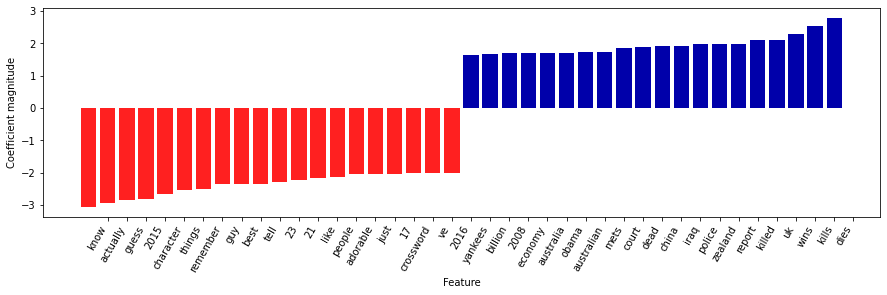

In [19]:
coefs = model.coef_
feature_names = vect.get_feature_names()

visualize_coefficients(coefs, feature_names, n_top_features=20)

The AUC score of the test test using the logistic model 1 is 0.9890, which is a desirable result. The graph above shows the visualization of the coefficients in the model. From the graph, we can see that words like "dies", "kills" are some of the most significant indicator that the message is clickbait, while words like "know" or "actually" are significant indicators of messages that are not clickbait. 

##### Vectorization Method 2 TfidfVectorizer ngram_range=(1,3)

In [24]:
vect1 = TfidfVectorizer(ngram_range=(1,3), min_df=5, norm=None, stop_words="english")
X_train2 = vect1.fit_transform(X_train)
X_test2 = vect1.transform(X_test)
y_train2 = y_train
y_test2 = y_test

The second vectorization method would be TfidVectorizer with ngram_range(1,2), which means that unigrams, bigrams and trigrams are all extracted. 

Logistic Model 1

In [25]:
scores = cross_val_score(LogisticRegression(C = 0.1), X_train2, y_train2, cv=5)
print("Mean cross-validation accuracy: {:.4f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.9478


Logistic Model 2

In [26]:
scores = cross_val_score(LogisticRegression(C = 1), X_train2, y_train2, cv=5)
print("Mean cross-validation accuracy: {:.4f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.9379


Logistic Model 3

In [27]:
scores = cross_val_score(LogisticRegression(C = 0.01), X_train2, y_train2, cv=5)
print("Mean cross-validation accuracy: {:.4f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.9501


From the cross-validation acuracy scores from the three logistic models, model 3 has the highest accuracy score with 0.95. Therefore, model 3 should be the best model used for prediction. 

Final Model

In [29]:
log_regression = LogisticRegression(C=0.01)
model = log_regression.fit(X_train2,y_train2)

y_pred_proba2 = log_regression.predict_proba(X_test2)[:,1]

In [30]:
from sklearn import metrics
auc = metrics.roc_auc_score(y_test2, y_pred_proba2)
print(auc)

0.9884307719384382


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


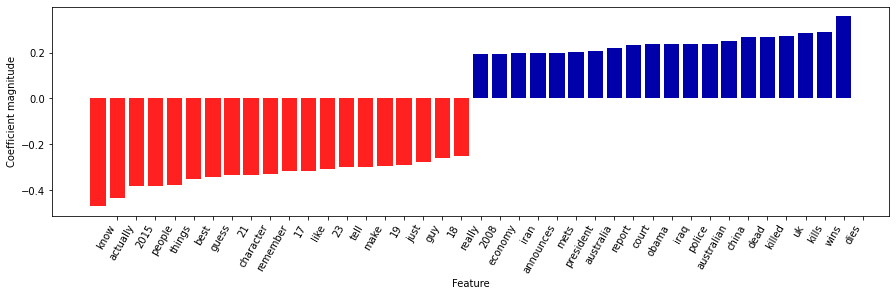

In [32]:
coefs = model.coef_
feature_names = vect1.get_feature_names()

visualize_coefficients(coefs, feature_names, n_top_features=20)

The AUC value for the logistic model with C = 0.01 is 0.988. The graph above shows that words like "dies", "wins" are some of the most significant indicator of a clickbait message, and words like "know", and "actually" are significant indicators of a non-clickbait message.



##### Vectorization Method 3 Lemma Tokenizer



In [33]:
! pip install nltk

In [42]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer

# instantiate nltk's Porter stemmer
stemmer = nltk.stem.PorterStemmer()

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

# nltk.download('punkt') # may need to updated nltk by downloading modules
# nltk.download('wordnet') # may need to updated nltk by downloading modules

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    
# define a count vectorizer with the custom tokenizer

lemma_vect = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words="english")  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [43]:
X_train3 = lemma_vect.fit_transform(X_train)
X_test3 = lemma_vect.transform(X_test)
y_train3 = y_train
y_test3 = y_test

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  % sorted(inconsistent)


The third vectorization method would be lemmatokenizer method.

Logistic Model 1:

In [44]:
scores = cross_val_score(LogisticRegression(C = 0.1), X_train3, y_train3, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.93


Logistic Model 2:

In [45]:
scores = cross_val_score(LogisticRegression(C = 1), X_train3, y_train3, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.95


Logistic Model 3:

In [46]:
scores = cross_val_score(LogisticRegression(C = 0.01), X_train3, y_train3, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.89


From the cross-validation accuracy scorew, model 2 with C = 1 should be considered as the best model with the accuracy score of 0.97.

Final Model:

In [47]:
log_regression = LogisticRegression(C=1)
model = log_regression.fit(X_train3, y_train3)

y_pred_proba3 = log_regression.predict_proba(X_test3)[:,1]

In [48]:
from sklearn import metrics
auc = metrics.roc_auc_score(y_test3, y_pred_proba3)
print(auc)

0.9899192031215882


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


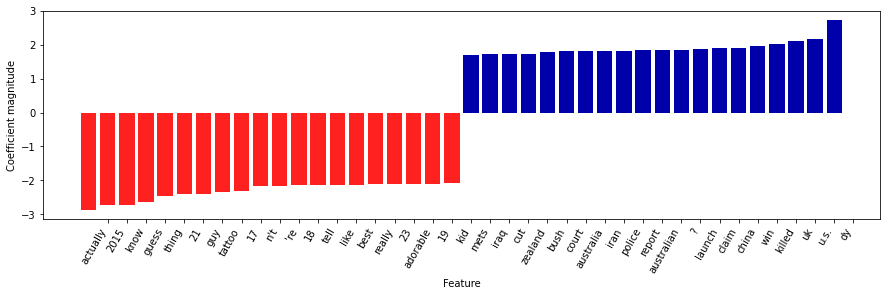

In [49]:
coefs = model.coef_
feature_names = lemma_vect.get_feature_names()

visualize_coefficients(coefs, feature_names, n_top_features=20)

The AUC value for the logistic regression model C = 1 is 0.9899. The graph above shows the visualization of the coefficients in the model. We can see that words like "dy", "u.s." are some of the significant indicator that a message is a click bait. However, words like "actually" and "know" are strong indicators that a message is not a click bait. 

### Part 2: Build a predictive neural network using Keras

In [90]:
from tensorflow.keras.models import Sequential
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [157]:
data = pd.read_csv("iris.csv")

data.loc[data["Species"]=="setosa","Species"]=0
data.loc[data["Species"]=="versicolor","Species"]=1
data.loc[data["Species"]=="virginica","Species"]=2

In [158]:
data = data.iloc[:,1:]
y = data['Species']
X = data.loc[:, data.columns != 'Species']

y = pd.get_dummies(y)

In [159]:
data.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [94]:
X.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [95]:
y.head()

,0,1,2
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [96]:
print(y.shape)

(150, 3)


In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### Model 1: Simple Model with hiddennode both 5

In [161]:
model1 = Sequential()
model1.add(Dense(5, input_dim=4, activation='relu'))
model1.add(Dense(5, activation='relu'))
model1.add(Dense(3, activation='softmax'))

In [162]:
model1.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [163]:
model1.fit(X_train, y_train,
          epochs=40,
          batch_size=128)

Epoch 1/40
1/1 [==============================] - 0s 391ms/step - loss: 5.8302 - accuracy: 0.3036
Epoch 2/40
1/1 [==============================] - 0s 7ms/step - loss: 3.3981 - accuracy: 0.0000e+00
Epoch 3/40
1/1 [==============================] - 0s 6ms/step - loss: 2.8538 - accuracy: 0.3393
Epoch 4/40
1/1 [==============================] - 0s 16ms/step - loss: 2.4510 - accuracy: 0.1071
Epoch 5/40
1/1 [==============================] - 0s 7ms/step - loss: 2.1111 - accuracy: 0.3304
Epoch 6/40
1/1 [==============================] - 0s 6ms/step - loss: 1.8096 - accuracy: 0.3304
Epoch 7/40
1/1 [==============================] - 0s 6ms/step - loss: 1.5553 - accuracy: 0.3304
Epoch 8/40
1/1 [==============================] - 0s 9ms/step - loss: 1.3556 - accuracy: 0.3393
Epoch 9/40
1/1 [==============================] - 0s 7ms/step - loss: 1.2132 - accuracy: 0.3393
Epoch 10/40
1/1 [==============================] - 0s 9ms/step - loss: 1.1198 - accuracy: 0.3393
Epoch 11/40
1/1 [===============

In [164]:
results = model1.evaluate(X_test, y_test)

print('Final test set loss: {:4f}'.format(results[0]))
print('Final test set accuracy: {:4f}'.format(results[1]))

2/2 [==============================] - 0s 7ms/step - loss: 0.5154 - accuracy: 0.8421
Final test set loss: 0.515366
Final test set accuracy: 0.842105


#### Model 2: Simple model with hiddenodes both 10

In [165]:
model2 = Sequential()
model2.add(Dense(10, input_dim=4, activation='relu'))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(3, activation='softmax'))

In [166]:
model2.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [167]:
model2.fit(X_train, y_train,
          epochs=40,
          batch_size=128)

Epoch 1/40
1/1 [==============================] - 0s 395ms/step - loss: 1.8949 - accuracy: 0.3125
Epoch 2/40
1/1 [==============================] - 0s 6ms/step - loss: 1.6877 - accuracy: 0.3125
Epoch 3/40
1/1 [==============================] - 0s 9ms/step - loss: 1.5308 - accuracy: 0.3125
Epoch 4/40
1/1 [==============================] - 0s 6ms/step - loss: 1.4119 - accuracy: 0.3125
Epoch 5/40
1/1 [==============================] - 0s 6ms/step - loss: 1.3212 - accuracy: 0.3125
Epoch 6/40
1/1 [==============================] - 0s 10ms/step - loss: 1.2522 - accuracy: 0.3125
Epoch 7/40
1/1 [==============================] - 0s 7ms/step - loss: 1.2000 - accuracy: 0.3125
Epoch 8/40
1/1 [==============================] - 0s 8ms/step - loss: 1.1606 - accuracy: 0.3125
Epoch 9/40
1/1 [==============================] - 0s 5ms/step - loss: 1.1307 - accuracy: 0.3125
Epoch 10/40
1/1 [==============================] - 0s 6ms/step - loss: 1.1079 - accuracy: 0.3125
Epoch 11/40
1/1 [===================

In [169]:
results = model2.evaluate(X_test, y_test)

print('Final test set loss: {:4f}'.format(results[0]))
print('Final test set accuracy: {:4f}'.format(results[1]))

2/2 [==============================] - 0s 6ms/step - loss: 0.9716 - accuracy: 0.7105
Final test set loss: 0.971609
Final test set accuracy: 0.710526


The final test set accuracy for model 2 is 0.71, which is lower than the test set accuracy for model 1, which is the model with number of hiddennodes in each layer of 5.

Therefore, we cannot conclude that a larger number of hiddennodes in each layer will result in a better result. 

#### Model 3: GridSearchCV on the number of hidden nodes. 

In [170]:
def create_model(hiddennodes1 = 1, hiddennodes2 = 1):
	# create model
	model = Sequential()
	model.add(Dense(hiddennodes1, input_dim=4, activation='relu'))
	model.add(Dense(hiddennodes2, activation='relu'))
	model.add(Dense(3, activation='softmax'))
 
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
	return model

model = KerasClassifier(build_fn=create_model, epochs=100, verbose=0) # epochs arg is built in to Scikit learn's... 
                                                                      # KerasClassifier

# Building a simple search grid that adjusts epochs
param_grid = dict(hiddennodes1=[1,5,10,20,30], hiddennodes2=[1,5,10,20,30])
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  if sys.path[0] == '':


In [171]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.972727 using {'hiddennodes1': 20, 'hiddennodes2': 30}


We are using GridsearchCV to tune the number of hidden nodes in each hidden layer, and according to the result above, the best number of hidden nodes for the model would be 20 in layer 1 and 30 in layer 2. 

That's also the number of hidden nodes to include for the model. 

In [173]:
model = Sequential()
model.add(Dense(20, input_dim=4, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(3, activation='softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.summary()

Model: "sequential_386"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1158 (Dense)          (None, 20)                100       
                                                                 
 dense_1159 (Dense)          (None, 30)                630       
                                                                 
 dense_1160 (Dense)          (None, 3)                 93        
                                                                 
Total params: 823
Trainable params: 823
Non-trainable params: 0
_________________________________________________________________


In [174]:
model_history = model.fit(X_train, y_train, verbose=2, batch_size=5, epochs=100)

Epoch 1/100
23/23 - 0s - loss: 1.2337 - accuracy: 0.2411 - 403ms/epoch - 18ms/step
Epoch 2/100
23/23 - 0s - loss: 0.8823 - accuracy: 0.6518 - 35ms/epoch - 2ms/step
Epoch 3/100
23/23 - 0s - loss: 0.7450 - accuracy: 0.6339 - 27ms/epoch - 1ms/step
Epoch 4/100
23/23 - 0s - loss: 0.6540 - accuracy: 0.6339 - 31ms/epoch - 1ms/step
Epoch 5/100
23/23 - 0s - loss: 0.5943 - accuracy: 0.7054 - 29ms/epoch - 1ms/step
Epoch 6/100
23/23 - 0s - loss: 0.5354 - accuracy: 0.7500 - 35ms/epoch - 2ms/step
Epoch 7/100
23/23 - 0s - loss: 0.4930 - accuracy: 0.7589 - 37ms/epoch - 2ms/step
Epoch 8/100
23/23 - 0s - loss: 0.4925 - accuracy: 0.8214 - 47ms/epoch - 2ms/step
Epoch 9/100
23/23 - 0s - loss: 0.4366 - accuracy: 0.8393 - 44ms/epoch - 2ms/step
Epoch 10/100
23/23 - 0s - loss: 0.4249 - accuracy: 0.8214 - 32ms/epoch - 1ms/step
Epoch 11/100
23/23 - 0s - loss: 0.3931 - accuracy: 0.8393 - 26ms/epoch - 1ms/step
Epoch 12/100
23/23 - 0s - loss: 0.3823 - accuracy: 0.8750 - 36ms/epoch - 2ms/step
Epoch 13/100
23/23 - 0s

##### Evaluting using test dataset.

In [129]:
results = model.evaluate(X_test, y_test)

print('Final test set loss: {:4f}'.format(results[0]))
print('Final test set accuracy: {:4f}'.format(results[1]))

2/2 [==============================] - 0s 5ms/step - loss: 0.0604 - accuracy: 1.0000
Final test set loss: 0.060438
Final test set accuracy: 1.000000


In [175]:
y_test.shape

(38, 3)

In [176]:
prediction=model.predict(X_test)
length=len(prediction)
y_label= np.argmax(model.predict(X_test), axis=-1)
predict_label=np.argmax(prediction,axis=1)

In [177]:
predict_label

array([1, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 1,
       0, 2, 1, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0])

In [178]:
y_label

array([1, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 1,
       0, 2, 1, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0])

In [179]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [180]:
accuracy = accuracy_score(y_label, predict_label)
print('Accuracy: %f' % accuracy)

Accuracy: 1.000000


If we use the model to make prediction based on the test dataset, we can see that we are achieving 100% accuracy on the test dataset. 

In [181]:
# list all data in history
print(model_history.history.keys())

dict_keys(['loss', 'accuracy'])


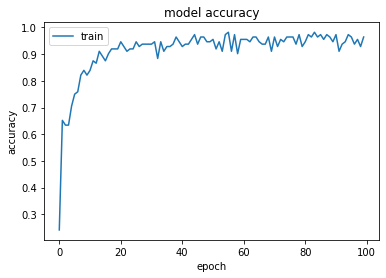

In [182]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

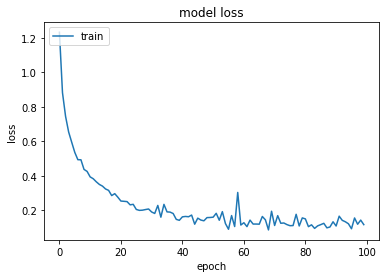

In [183]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

From the graphs shown above, we can see that as number of epochs increase, the model accuracy increases exponentially, with the model loss decreases exponentially as well. Therefore, the increase number of epochs will increase the model accuracy and helpus get a better prediction model. 